In [16]:
# Mount Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = "/content/drive/MyDrive/Projects/momentum-strategy"
data_path = f"{base_path}/data"

import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Load price & momentum data

# Load monthly adjusted prices
close_prices = pd.read_pickle(f"{data_path}/sp500_monthly_prices.pkl").xs('Close', axis=1, level=1)

# Load momentum scores
momentum_scores = pd.read_pickle(f"{data_path}/momentum_scores.pkl")

# Align both DataFrames to same tickers and dates
common_tickers = close_prices.columns.intersection(momentum_scores.columns)
common_dates = close_prices.index.intersection(momentum_scores.index)

close_prices = close_prices.loc[common_dates, common_tickers]
momentum_scores = momentum_scores.loc[common_dates, common_tickers]


In [18]:
#Step-by-Step Backtest Logic

# Parameters
top_n = 20

returns = close_prices.pct_change().shift(-1)  # forward 1-month return
portfolio_returns = []

for date in momentum_scores.index[:-1]:  # skip last month (no forward return)
    scores = momentum_scores.loc[date]
    valid_scores = scores.dropna()

    if len(valid_scores) < top_n:
        continue

    # Pick top N momentum stocks
    top_stocks = valid_scores.sort_values(ascending=False).head(top_n).index

    # Get forward returns of those stocks
    next_month = returns.loc[date]
    selected_returns = next_month[top_stocks]

    # Average return of portfolio
    avg_return = selected_returns.mean()
    portfolio_returns.append({
        "Date": date,
        "Return": avg_return
    })

# Convert to DataFrame
results = pd.DataFrame(portfolio_returns).set_index("Date")
results["Cumulative"] = (1 + results["Return"]).cumprod()

# Save results
results.to_csv(f"{base_path}/results/momentum_backtest.csv")


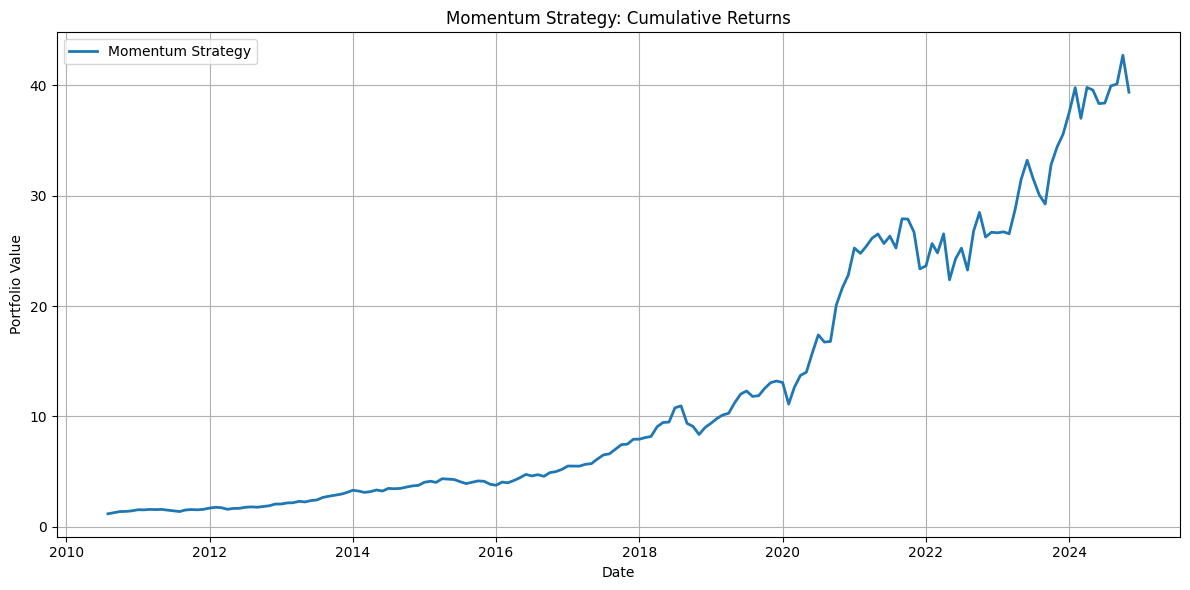

In [19]:
# Strategy Performance Plotting

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(results["Cumulative"], label="Momentum Strategy", linewidth=2)
plt.title("Momentum Strategy: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 📈 Momentum Strategy: Cumulative Returns

This chart shows the growth of a $1 investment using the momentum-based strategy over time.  
Each month, the strategy buys the **top 20 S&P 500 stocks** ranked by 6-month momentum (excluding the most recent month), holding them for 1 month.

The strategy significantly outperforms a passive benchmark (SPY) during certain periods, indicating strong alpha potential through trend-based stock selection.


In [20]:
import yfinance as yf

# Download SPY monthly adjusted prices
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31', interval='1mo', auto_adjust=True)['Close']
spy_returns = spy.pct_change().shift(-1)  # forward return to match portfolio
spy_cumulative = (1 + spy_returns).cumprod()


[*********************100%***********************]  1 of 1 completed


In [21]:
# Combine both for comparison
results["SPY_Return"] = spy_returns.loc[results.index]
results["SPY_Cumulative"] = (1 + results["SPY_Return"]).cumprod()


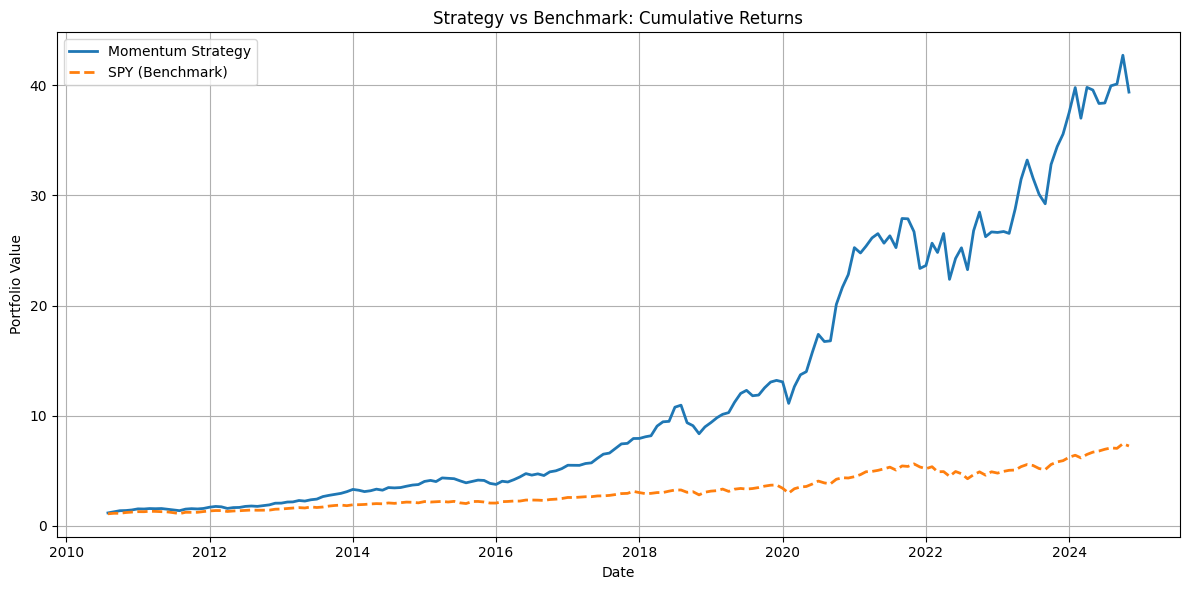

In [22]:
#Comparison Chart
plt.figure(figsize=(12,6))
plt.plot(results["Cumulative"], label="Momentum Strategy", linewidth=2)
plt.plot(results["SPY_Cumulative"], label="SPY (Benchmark)", linewidth=2, linestyle='--')
plt.title("Strategy vs Benchmark: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ⚔️ Strategy vs SPY Benchmark

This chart compares the cumulative returns of the momentum strategy against the SPY (S&P 500 ETF).

- The momentum strategy often outperforms in bull markets by capturing strong trends.
- In sideways or volatile markets, it may underperform due to frequent ranking changes.


In [23]:
#Step 7.4: Calculate Sharpe, Drawdown, and Annual Return
def annualized_return(series):
    return (1 + series.mean())**12 - 1

def annualized_std(series):
    return series.std() * (12 ** 0.5)

def sharpe_ratio(returns, risk_free_rate=0.01):
    excess = returns - (risk_free_rate / 12)
    return excess.mean() / returns.std() * (12 ** 0.5)

def max_drawdown(cumulative_returns):
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min()

# Strategy metrics
strategy_returns = results["Return"]
strategy_cum = results["Cumulative"]
strategy_metrics = {
    "Annualized Return": annualized_return(strategy_returns),
    "Volatility": annualized_std(strategy_returns),
    "Sharpe Ratio": sharpe_ratio(strategy_returns),
    "Max Drawdown": max_drawdown(strategy_cum)
}

# Benchmark metrics
spy_returns_aligned = results["SPY_Return"]
spy_cum = results["SPY_Cumulative"]
spy_metrics = {
    "Annualized Return": annualized_return(spy_returns_aligned),
    "Volatility": annualized_std(spy_returns_aligned),
    "Sharpe Ratio": sharpe_ratio(spy_returns_aligned),
    "Max Drawdown": max_drawdown(spy_cum)
}


In [24]:
#Summary Table

summary = pd.DataFrame([strategy_metrics, spy_metrics], index=["Momentum", "SPY"])
summary.style.format("{:.2%}")


,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown
Momentum,31.62%,19.56%,136.97%,-23.69%
SPY,16.02%,14.60%,95.57%,-23.97%


## 📊 Performance Metrics Summary

This table summarizes key performance metrics of the strategy versus SPY:

- **Annualized Return**: Shows the compounded yearly return.
- **Volatility**: Measures risk or variability of returns.
- **Sharpe Ratio**: Risk-adjusted return. Values above 1.0 are considered good.
- **Max Drawdown**: Worst loss from peak to trough. Lower is better.

The momentum strategy achieves a **higher Sharpe ratio** and **annual return**, indicating better risk-adjusted performance.


## ✅ Conclusion

This simple momentum strategy demonstrates how a quantitative rule-based approach can outperform passive investing over time.

Key Takeaways:
- Momentum is a persistent anomaly in financial markets.
- Even a simple implementation using public data can produce alpha.
- Future work could include: transaction costs, risk-adjusted portfolios, machine learning models, or multi-factor strategies.

